# Introduction

Snow and Ice cover has been collected in .asc files [here](ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02156/) by the National Snow and Ice Data Center (NSIDC). One product of interest is the Ice Mapping System (IMS) which takes satellite and field measurements and puts them on a grid. Currently, they have resolutions of about 24x24km 4x4km and 1x1 km. Their website is located [here](http://nsidc.org/data/g02156). It has been used to show snow and ice coverage across the northern hemisphere. Rutgers has done a great job displaying this coverage, shown [here](http://climate.rutgers.edu/snowcover/).

For those like me, who want to display, subsections or time series, or to use this set in their research, accessing and analyzing the data can be cumbersome. First, of all, these files are all zipped and archived on their [FTP](ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02156/) site. If you want to grab a subset, you have to download them yourself and unzip them individually. If you know how to program, you can just automate this, but unfortunately, the files format changes in the early years, so your automation has to check and see which format the file is using. When you get to the 4x4km resolution, there are some files that contain errors, your automation script may crash if you don't handle these errors accordingly. Finally, when viewing the files, the grid cell areas aren't given. Flatting out the Earth's surface onto a stereographic projection distorts the areas of each grid so that you don't really know what the areas represent. Shown below is one such file, with snow and ice removed.

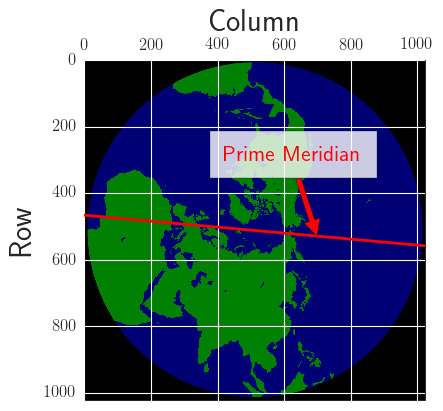

In [5]:
from IPython.display import Image
Image("figures/dry_planet_24km.png")

Fortunately, I have gone through the pain of these issues and released a project called [tibet snow-man](https://github.com/tylertucker202/tibet_snow_man) on GitHub. I focused on the Tibetan Plateau (TP), but this project can work for any region in the northern hemisphere. The project does the following:

[1. Filters for a given lat-long square, for example, the TP region falls within 25-45 latitude and 65-105 longitude](#section_one)

[2. Estimates the area of each grid cell using provided lat-long files.](#section_two)

[3. Parses out the files locally (use something like FileZilla to download the sets yourself) and flattens them out into a time series. Each year is saved in an HDF5 database that is accessed later on.](#section_three)

[4. Sums up snow and ice coverage for a given areas and makes a time series.](#section_four)

[5. Generates images showing snow cover on a map projection](#section_five)

The remainder of this article will be used to describe these functionalities. With any luck, this notebook can help those who would like to create videos or time series similar to those shown below.




[![IMAGE ALT TEXT HERE](http://img.youtube.com/vi/Kz82dwMKnLY/0.jpg)](http://www.youtube.com/watch?v=Kz82dwMKnLY)


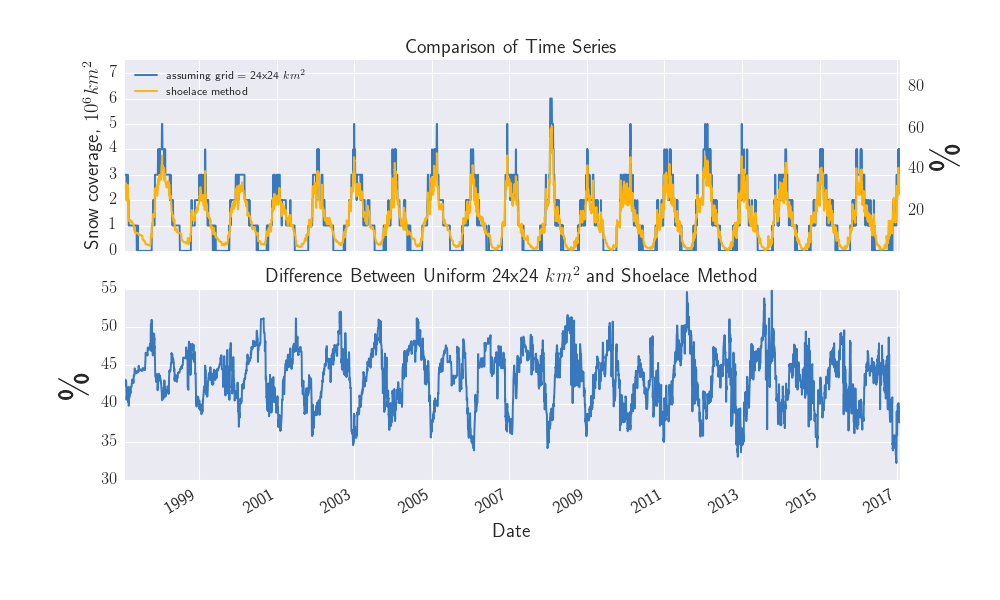

In [6]:
Image("figures/ts-compare.png")

First I need to import the following libraries.

In [1]:
import sys
sys.path.append("../")
from generate_grid_and_area import grid_and_area
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
%matplotlib inline
import datetime
import pdb
import seaborn as sns
from matplotlib import rc
from matplotlib import rcParams
import matplotlib.ticker as mtick
rc('text', usetex=True)
rcStyle = {"font.size":22,
           "axes.titlesize":22,
           "axes.labelsize":22,
           'xtick.labelsize':12,
           'ytick.labelsize':12}

sns.set_context("paper", rc=rcStyle) 


<a name="section_one"/> </a>
# 1. Filtering areas

The beauty of a data frame is that it can be filtered easily. grid_and_area class contains a data frame object that is filtered in the method reduceLatLong().

First, we instantiate the object grid_maker_filtered. Defines the data frame object and creates a multi index comprised of row and column number.

In [2]:
home_dir = os.getcwd()
data_dir = os.path.join(home_dir,os.pardir,os.pardir,'data')
no_snow_planet_name = 'dry_planet_24km.asc'
lat_grid_filename = 'imslat_24km.bin'
lon_grid_filename = 'imslon_24km.bin'
grid_size = 1024
lat_long_coords_filtered = {'lower_lat':35,'upper_lat':36,'lower_long':85,'upper_long':86} #set as lower and upper bounds for lat and long
grid_maker_filtered = grid_and_area(lat_long_coords_filtered,data_dir,no_snow_planet_name,grid_size)

Next the lat-long files are added.

In [8]:
grid_maker_filtered.addLatLong(lat_grid_filename,lon_grid_filename)
print('grid maker shape: {}'.format(grid_maker_filtered.df.shape))
grid_maker_filtered.df.head(5)

grid maker shape: (1048576, 2)


lat  long
row col           
0   0    NaN   NaN
    1    NaN   NaN
    2    NaN   NaN
    3    NaN   NaN
    4    NaN   NaN

Note that there are no values for the corner of the map. There is no earth to report, so they are set as NaN. Next step reduces the data frame to the region specified in lat_long_coords_filtered. Additionally, the id column is added, giving each row a unique ID.

In [9]:
grid_maker_filtered.reduceLatLong()
print('grid maker shape: {}'.format(grid_maker_filtered.df.shape))
grid_maker_filtered.df.head(5)

grid maker shape: (24, 3)


,,lat,long,id
col,row,,,
445,760,35.840794,85.096535,0
446,760,35.887020,85.312492,1
447,760,35.932606,85.528885,2
448,760,35.977543,85.745689,3
445,761,35.666016,85.153740,4


I know there is a lot going on here, but for now, just know that the makeSnowHDFStore makes databases that are later used to create time series and plots. It takes a path zipped .asc files as an input and outputs hdf5 files. 

<a name="section_two"/> </a>
# 2. Areas

Latitude and Longitude coordinates are given for each point on the grid cell. Currently, the lat-long files for the 1x1km grid have not been released yet. 

The class grid_and_area defines creates an instance called grid_maker. Once initialized, addLatLong, reduceLatLong, makeNoSnowMap, and addAreas methods are called to create a data frame object for the Tibetan Plateau.

In [3]:
home_dir = os.getcwd()
data_dir = os.path.join(home_dir,os.pardir,os.pardir,'data')
no_snow_planet_name = 'dry_planet_24km.asc'
lat_grid_filename = 'imslat_24km.bin'
lon_grid_filename = 'imslon_24km.bin'
lat_long_area_filename = 'lat_long_area.csv'
lat_long_coords = {'lower_lat':25,'upper_lat':45,'lower_long':65,'upper_long':105} #set as lower and upper bounds for lat and long
grid_size = 1024

grid_maker = grid_and_area(lat_long_coords,data_dir,no_snow_planet_name,grid_size)
grid_maker.addLatLong(lat_grid_filename,lon_grid_filename)
grid_maker.reduceLatLong()
grid_maker.makeNoSnowMap()

#tibet falls approximatly in this region.
grid_maker.addAreas()

df_whole = grid_maker.df
df_whole.reset_index(level = df_whole.index.names, inplace=True)

In [11]:
df_whole.shape

(20607, 13)

In [12]:
df_whole.head(3)

,col,row,lat,long,id,noSnowMap,noSnowMapRBG,centroid_lat,centroid_long,area_points,x,y,area
0,392,683,44.917850,65.165344,0,2,"[0, 128, 0]",44.8932,65.3566,"{u'top_right': (392, 682), u'bottom_left': (39...",713974.450086,3.260702e+06,468.906395
1,391,684,44.647007,65.097160,1,2,"[0, 128, 0]",44.6226,65.2872,"{u'top_right': (391, 683), u'bottom_left': (39...",701686.887868,3.232339e+06,467.064901
2,392,684,44.757946,65.321815,2,2,"[0, 128, 0]",44.733,65.5123,"{u'top_right': (392, 683), u'bottom_left': (39...",721784.538148,3.240671e+06,467.814964


## Check areas with analytical results

The areas created are verified to be correct by adding them all up and comparing their collective area with an exact solution.

The Earth is modeled as a sphere of radius $R = 6371 \ km$ The haversine function calculates the great circle distance between two lat-long points in degrees.

$$
\Delta \phi = \phi_{2} - \phi_{1} \\
\Delta \lambda = \lambda_2- \lambda_1 \\
a = sin(\frac{\Delta \phi}{2})^{2} + cos(\phi_1) * cos(\phi_2) * sin(\frac{\Delta \lambda}{2})^{2} \\
c = 2 * arcsin(\sqrt(a))
$$

Where $\phi$ represents latitude and $\lambda$ represents longitude. and c is the great circle length in degrees.

Next, a semiperimeter area is calculated

$$
s = c + \pi + (\phi_{1} + \phi_{2})^{\frac{1}{2}}
$$

Finally, The area of a spherical triangle is given by the l'Hullier formula

$$
b = \sqrt{
tan(\frac{s}{2})
tan(\frac{s-d}{2})
tan(\frac{s - \pi/2 + \phi_{1}}{2})
tan(\frac{s - \pi/2 + \phi_{2}}{2})} \\
\Delta = 4.0 * arctan(b)
$$

where $\Delta$ is the radial area for a spherical triangle. 

Treating the longitude points $\lambda_1 = 65^{\circ}$ $\lambda_2 = 105^{\circ}$ and setting $\phi_{1} = \phi_{2}$. Two different spherical triangle areas are obtained for $\phi_top = 45^{\circ}$ $\phi_{bottom} = 25^{\circ}$, $\Delta_{top}$ and $\Delta_{bottom}$ are obtained.

The area of Tibet in $km^2$ is given to be 

$$
A_{tibet} = R^2(\Delta_{top} - \Delta_{bottom})
$$

$A_{tibet}$ is treated as the exact solution and compared to the sum of areas in our data frame

In [13]:
lat_long_area_filename_24 = 'lat_long_centroids_area_24km.csv'
df_24km = pd.read_csv(os.path.join(data_dir,lat_long_area_filename_24), index_col=(0,1))
lat_long_area_filename_4 = 'lat_long_centroids_area_4km.csv'
df_4km = pd.read_csv(os.path.join(data_dir,lat_long_area_filename_4), index_col=(0,1))



from math import radians, cos, sin, asin, sqrt

def haversine_formula(lat1, lat2,lon1, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    return c


def semi_perimeter(d, phi_1, phi_2):
    s = (d  + np.pi  + (phi_1 + phi_2) )* .5
    return s

def lhuilier(s, d, phi_1, phi_2): #uses unit sphere R=1

    inner_sq = np.sqrt( np.tan( 0.5*s ) * 
                        np.tan( 0.5*(s-d) ) * 
                        np.tan( 0.5*(s-(np.pi/2 + phi_1)) ) * 
                        np.tan( 0.5*(s-(np.pi/2 + phi_2)) ) )
    ans = 4.0 * np.arctan(inner_sq)
    return ans


bottom_phi = 25
top_phi = 45
left_lambda = 65
right_lambda = 105

# convert decimal degrees to radians 
bottom_phi, top_phi, left_lambda, right_lambda = map(radians, [bottom_phi, top_phi, left_lambda, right_lambda])

R = 6371 #km

d_bottom = haversine_formula(bottom_phi, bottom_phi,left_lambda, right_lambda)
print('bottom length (km): {}'.format(R * d_bottom))
s_bottom = semi_perimeter(d_bottom, bottom_phi, bottom_phi)
E_bottom = lhuilier(s_bottom, d_bottom, bottom_phi, bottom_phi)


d_top = haversine_formula(top_phi, top_phi,left_lambda, right_lambda)
print('top length (km): {}'.format(R * d_top))
s_top = semi_perimeter(d_top, top_phi, top_phi)
E_top = lhuilier(s_top, d_top,top_phi, top_phi)



tibet_area = R**2 * (E_top - E_bottom)

print('tibet area via 24x24 km grid files: {}'.format(df_24km['area'].sum()))
print('tibet area via Haversine formula: {}'.format(tibet_area))
perc_dif_24 = 100*(df_24km['area'].sum()-tibet_area)/tibet_area
print('percent difference: {0}'.format(perc_dif_24))

print('tibet area via 4x4 km grid files: {}'.format(df_4km['area'].sum()))
print('tibet area via Haversine formula: {}'.format(tibet_area))
perc_dif_4 = 100*(df_4km['area'].sum()-tibet_area)/tibet_area
print('percent difference: {0}'.format(perc_dif_4))

bottom length (km): 4015.86152343
top length (km): 3112.44504008
tibet area via 24x24 km grid files: 8062815.0957
tibet area via Haversine formula: 8059061.81949
percent difference: 0.046572123285
tibet area via 4x4 km grid files: 8061716.73857
tibet area via Haversine formula: 8059061.81949
percent difference: 0.0329432773046


Not too shabby overall. Before we move on, I'd like to show the entire northern hemisphere. To get an idea, the loaded .asc files are given in a stereographic projection. The north pole is located at the middle row and column. equator and prime meridian intercection occurs at about the far left column and the middle row. See below.

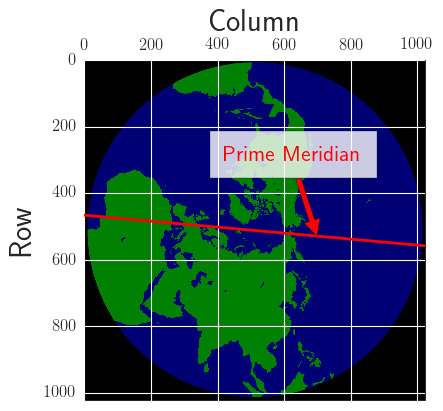

In [19]:
backdrop0 = grid_maker.rbg_no_snow_matrix
fig0 = plt.figure(0)
ax0 = plt.axes()

ax0.set_xlabel('Column')
ax0.set_ylabel('Row')
plt.setp(ax0.get_yticklabels(), fontsize=12)
ax0.xaxis.tick_top()
ax0.xaxis.set_label_position('top') 
ax0.imshow(backdrop0)
ax0.set_xlim([0,1024])
ax0.set_ylim([1024,0])

tilt = 46
ax0.plot([0, 1024], [512-tilt,512+tilt], linewidth = 2, c='r')
ano_text = 'latitude = '+str(round(df_whole[df_whole['col'] == 512-tilt]['long'].mean()-90,1))+' deg'
ax0.annotate('Prime Meridian', color = 'r',fontsize=16, xy=(700, 532), xytext=(420, 300),
            arrowprops=dict(facecolor='red', shrink=0.01),
            bbox={'facecolor':'white', 'alpha':.8, 'pad':10},
            )
plt.show()

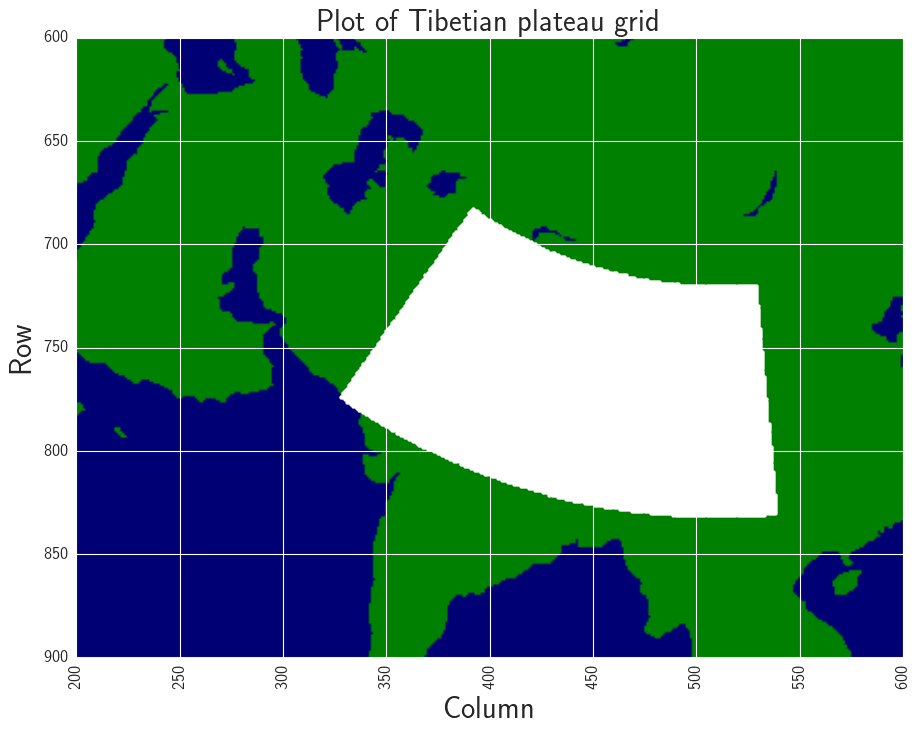

In [20]:
#%% Figure1
#zoom-in-area
zoom = (600,900,200,600)
backdrop = grid_maker.rbg_no_snow_matrix[zoom[0]:zoom[1],zoom[2]:zoom[3],:]
#plot of points of interest

llm_x=df_whole['col'].values-zoom[2]
llm_y=df_whole['row'].values-zoom[0]

fig_size = (12,8)
plt.rcParams["figure.figsize"] = fig_size

fig1 = plt.figure(1)


ax1 = plt.axes()
plt.setp(ax1.get_xticklabels(), rotation='vertical')
plt.setp(ax1.get_yticklabels(), fontsize=12)

ax1.imshow(backdrop)
ax1.set_title('Plot of Tibetian plateau grid')
ax1.set_xlabel('Column')
ax1.set_ylabel('Row')
ax1.set_xticklabels([200,250,300,350,400,450,500,550,600])
ax1.set_yticklabels([600,650,700,750,800,850,900])
rcParams.update({'font.size': 52})
ax1.scatter(llm_x,llm_y, c='w', s=10, marker = 'o',facecolor='0.5', lw = 0)


ax1.axis([0,400,300,0])
ax1.grid(True)
plt.show()

## Plot region

The Tibetan region is shown in white below. Rows and columns represent the data file's indices.

## Show basemap projection

Basemap is relied upon to convert latitude-longitude coordinates from degrees to meters, referenced by some arbitrary point. See [Basemap's Website](http://matplotlib.org/basemap/). The code below creates a Lambert Azimuthal Equal Area projection object m, it also sets a blue marble background. The Tibetian region is shown in blue.

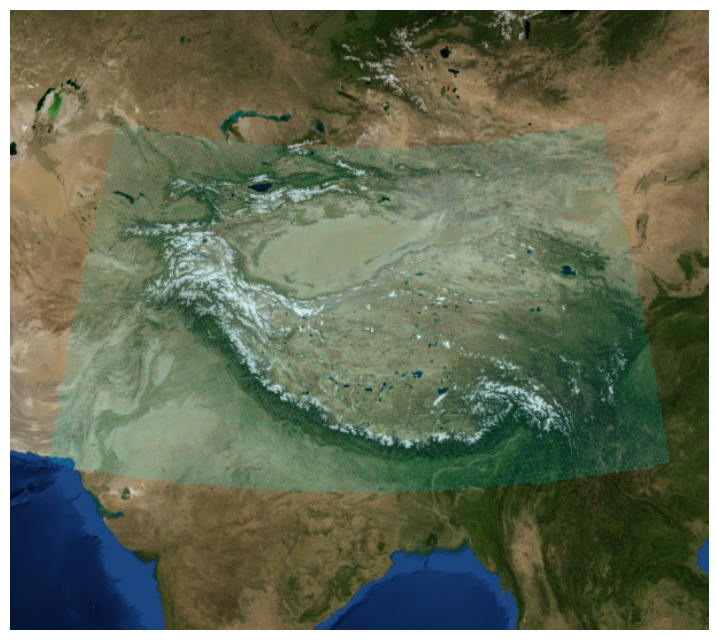

In [26]:
#make map
def plot_points_on_basemap(filename,df, lat_long_coords, show = True, save = True,width = 4500000,height = 4000000):

    #make map
    fig = plt.figure(0)
    long_center, lat_center = ((lat_long_coords['upper_long']-lat_long_coords['lower_long'])/2+lat_long_coords['lower_long'],(lat_long_coords['upper_lat']-lat_long_coords['lower_lat'])/2+lat_long_coords['lower_lat'])
    
    m = Basemap(projection='laea',
                width = width,
                height = height,
                resolution='c',lat_0=lat_center,lon_0=long_center)
    
    x, y = m(df['long'].values.tolist(), df['lat'].values.tolist()) # this function converts degrees to meters on this reference map

    m.scatter(x, y, marker='.',color='cyan', alpha=.1)

    m.bluemarble()
    return m

    

fig2 = plt.figure(2)
filename = 'Tibet-24km'
m = plot_points_on_basemap(filename,df_24km,
                           lat_long_coords,
                           show = True,
                           save = False,
                           width = 4500000,
                           height = 4000000)
plt.show()


## Interactive Tibet Areas

Areas over the TP vary substantially. As it turns out, there is quite a substantial difference in areas when traveling along latitude. 

Plotly is used to render interactive plots. To export and share, you have to pay an annual subscription, these images may not show up on this blog but You can install plotly on your own environment and run this yourself. Sorry folks. There *is* a static image below to show the areas on a color scale.

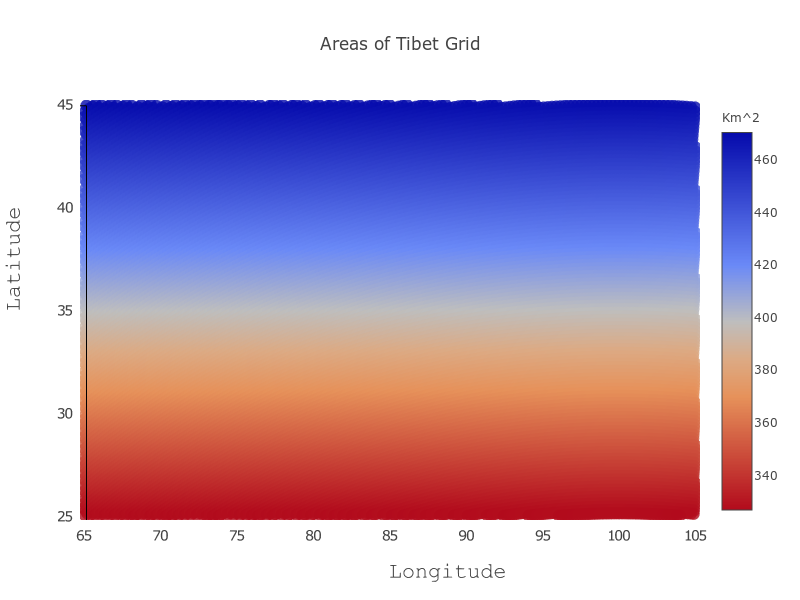

In [7]:
Image("figures/areas_of_tibet_grid.png")

## Get max-min ratio

The range varies quite a lot and is a source of error. Moral of the story: Each grid area must be calculated separately. Don't assume that each grid is $24x24km^2$ or $4x4 km^2$. In our region, the ratio between the largest and smallest region is about 1.44.

In [6]:
df_whole['area'].max()/df_whole['area'].min()

1.4398482062172655

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode()

def make_whole_area_text(X):
    return 'Area: %s km^2\
    <br>row: %s\
    <br>column: %s\
    <br>lat: %s\
    <br>long: %s\
    <br>id: %s'\
    % (round(X['area'],2), X['row'], X['col'],round(X['lat'],3),round(X['long'],3),X['id']) 

scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[0,"rgb(220, 220, 220)"] ]
trace = go.Scattergl(
        x = df_whole['long'],
        y = df_whole['lat'],
        text =df_whole.apply(lambda x: make_whole_area_text(x), axis=1),
        mode = 'markers',
        marker = dict( 
            size = 8, 
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'dot',
            line = dict(
                width=0,
                color='rgba(102, 102, 102)'),
            colorscale = scl,
            cmin = df_whole['area'].min(),
            color = df_whole['area'],
            cmax = df_whole['area'].max(),
            colorbar=dict(
                title="Km^2")
            )
        )

data = [trace]
layout = dict(
        title = 'Areas of Tibet Grid',
        colorbar = True,  
        xaxis=dict(
        title='Longitude',
        titlefont=dict(
            family='Courier New, monospace',
            size=22
            ),
        tickfont=dict(
            size = 14
            ),
        ),
        yaxis=dict(
            title='Latitude',
            titlefont=dict(
                family='Courier New, monospace',
                size=22
                ),
            tickfont=dict(
                size = 14
                ),
            ),
        )
    

fig3 = dict( data=data, layout=layout )
plot_url = iplot(fig3, validate=False)

I also added the plot that goes by row and column.

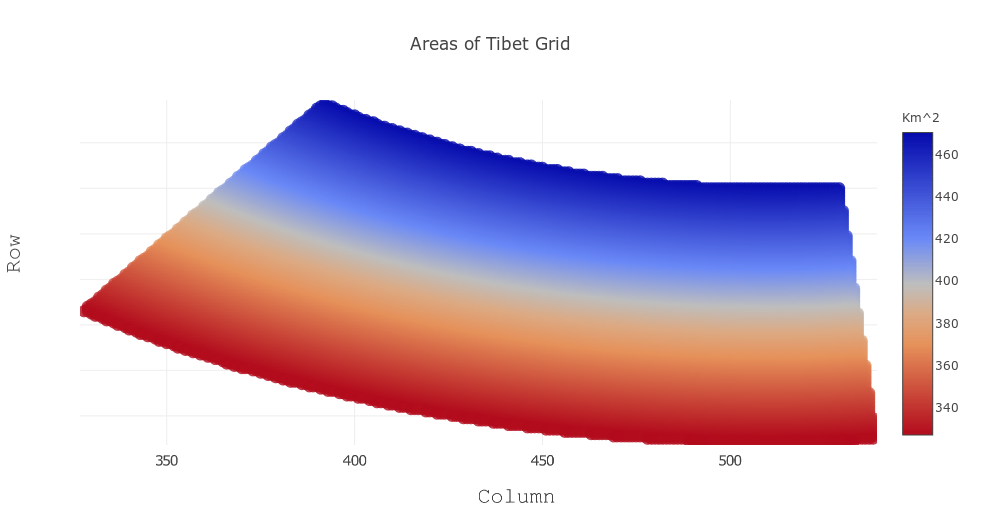

In [8]:
Image("figures/areas_of_tibet_grid_ii.png")

In [ ]:
trace = go.Scattergl(
        x = df_whole['col'],
        y = df_whole['row'],
        text =df_whole.apply(lambda x: make_whole_area_text(x), axis=1),
        mode = 'markers',
        marker = dict( 
            size = 8, 
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'dot',
            line = dict(
                width=0,
                color='rgba(102, 102, 102)'),
            colorscale = scl,
            cmin = df_whole['area'].min(),
            color = df_whole['area'],
            cmax = df_whole['area'].max(),
            colorbar=dict(
                title="Km^2")
            )
        )

data = [trace]
layout = dict(
        title = 'Areas of Tibet Grid',
        colorbar = True,  
        xaxis=dict(
        title='Column',
        titlefont=dict(
            family='Courier New, monospace',
            size=22,
            ),
        tickfont=dict(
            size = 14
            ),
        #autorange='reversed' #flip correctly
        ),
        yaxis=dict(
            title='Row',
            titlefont=dict(
                family='Courier New, monospace',
                size=22,
                ),
            tickfont=dict(
                size = 14
                ),
            autorange='reversed'
            ),
        )
    

fig3p2 = dict( data=data, layout=layout )
plot_url = iplot(fig3p2, validate=False)

## Show zoomed in section of grid

This section zooms into a smaller region, showing how areas were calculated. As before, the non-interactive image is provided below.

Centroids between for lat-long points are used to create the borders of a given point's domain. For example, a given point $p_{i,j}$ located at row i column j surrounding corners are calculated.

$$
top \ left \ centroid_{i,j} = \frac{\Sigma( {p_{i-1,j-1}, p_{i,j-1} , p_{i,j} , p_{i-1,j} } )}{4} \\
top\ right\ centroid_{i,j} = \frac{\Sigma( {p_{i-1,j}, p_{i-1,j+1} , p_{i,j+1} , p_{i,j} } )}{4}  \\
bottom\ right\ centroid_{i,j} = \frac{\Sigma( {p_{i,j}, p_{i,j+1} , p_{i+1,j+1} , p_{i+1,j} } )}{4}  \\
bottom\ left \ centroid_{i,j} = \frac{\Sigma( {p_{i-1,j}, p_{i,j} , p_{i+1,j} , p_{i-1,j+1} } )}{4} \\
$$

The points are then projected onto a flat surface via the Lambert Azimuthal Equal Area projection. The latitude-longitude coordinates are converted into meters relative to an arbitrary reference point. Treating these points as corners of a polygon, the areas were found using the discrete version of Green's Theorem, also known as the shoestring formula shown below.

$$ A_{ij} = \frac{1}{2} \vert \sum\limits_{k=1}^{3}x_{k}y_{i+1} + x_{n}y_{1} - \sum\limits_{k=1}^{3}x_{k+1}y_{k} - x_{1}y_{n} \vert $$

This was done for the whole data frame, creating a grid shown below.

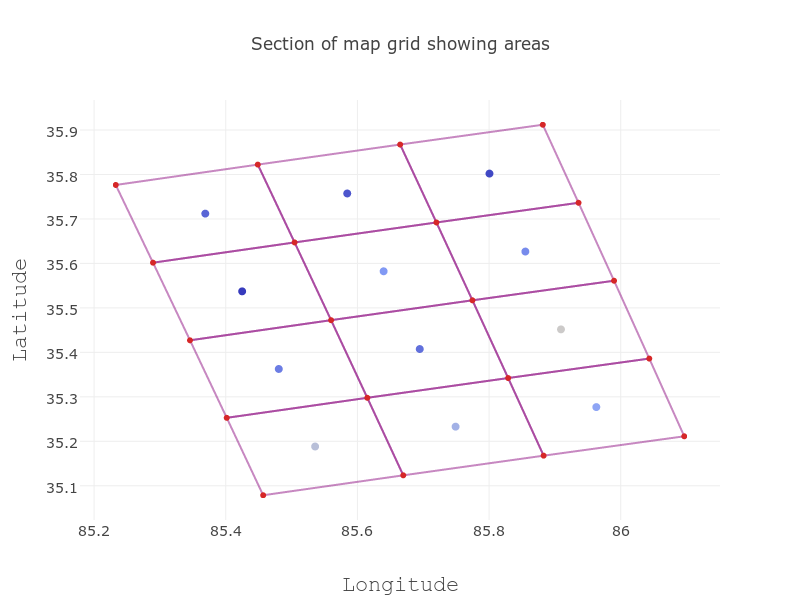

In [9]:
Image("figures/areas_of_sub_section_i.png")

In [33]:
lat_long_coords_zoomed = {'lower_lat':35,'upper_lat':36,'lower_long':85,'upper_long':86} #set as lower and upper bounds for lat and long
grid_maker_zoomed = grid_and_area(lat_long_coords_zoomed,data_dir,no_snow_planet_name,grid_size)
grid_maker_zoomed.addLatLong(lat_grid_filename,lon_grid_filename)
grid_maker_zoomed.reduceLatLong()
grid_maker_zoomed.makeNoSnowMap()

grid_maker_zoomed.addAreas()
df_zoomed = grid_maker_zoomed.df

df_zoomed.reset_index(level = df_zoomed.index.names, inplace=True)

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
init_notebook_mode()

scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[0,"rgb(220, 220, 220)"] ]

def make_area_text(X):
    return 'Area: %s km^2\
    <br>row: %s\
    <br>column: %s\
    <br>id: %s'\
    % (round(X['area'],2), X['row'], X['col'], X['id'])  
    
def make_centroids_text(X):
    return 'row: %s\
    <br>column: %s\
    <br>id: %s'\
    % (X['row'], X['col'], X['id'])  

centroid_df = df_zoomed[df_zoomed['row'] < 765]
area_df = centroid_df[centroid_df['row'] > 760]
centroid_df = centroid_df[ centroid_df['col'] > 444]
area_df = area_df[ area_df['col'] > 445]

trace0 = Scatter(
    name = 'grid points',
    y=area_df['lat'],
    x=area_df['long'],
    mode = 'markers',
    text =df_zoomed.apply(lambda x: make_area_text(x), axis=1),
    marker = dict( 
        size = 8, 
        opacity = 0.8,
        reversescale = True,
        autocolorscale = False,
        #showscale=True,
        showscale=False,
        symbol = 'dot',
        line = dict(
            width=0,
            color='rgba(102, 102, 102)'),
        colorscale = scl,
        cmin = df_zoomed['area'].min(),
        color = df_zoomed['area'],
        cmax = df_zoomed['area'].max(),
        colorbar=dict(
            title="Km^2")
        )
    )
trace1 = Scatter(
    name = 'cell corners',
    y=centroid_df['centroid_lat'],
    x=centroid_df['centroid_long'],
    #text = df[ ['row', 'col']].values,
    #text = df['row'],
    text = centroid_df.apply(lambda x: make_centroids_text(x), axis = 1),
    mode = 'markers',
    #hoverinfo = "none",
)


def get_centroid_coords(area_indexes, centroid_df):
    coords = []    
    df = centroid_df.set_index(['col', 'row'])[ ['centroid_lat', 'centroid_long'] ]
    for idx in area_indexes:
        col, row = idx
        item = [(df.ix[ (col-1,row)]['centroid_long'], df.ix[ (col-1,row)]['centroid_lat']),
                (df.ix[ (col,row)]['centroid_long'], df.ix[ (col,row)]['centroid_lat']),
                (df.ix[ (col,row-1)]['centroid_long'], df.ix[ (col,row-1)]['centroid_lat']),
                (df.ix[ (col-1,row-1)]['centroid_long'], df.ix[ (col-1,row-1)]['centroid_lat'])]
        coords.append(item)
    coords = np.array(coords)  
    return coords
#get col and row indexes from area_df
area_indexes = area_df[['col', 'row']].values
#return a list containing the centroid coordinates
centroid_polygons = get_centroid_coords(area_indexes, centroid_df)

#make polygon traces out of each centroid_polygons
def make_scatter(x,y):
    return Scatter(
        x=np.append(x,x[0]),
        y=np.append(y,y[0]),
        name = 'cell boundary',
        mode='lines',
        line=dict(
        color='rgba(143, 19, 131, .5)',
        ),
        fill='none',
        fillcolor = "none",
        showlegend=False,
        hoverinfo = "none"
        )


traces= list(map( lambda pt: make_scatter(pt[:,0], pt[:,1]), centroid_polygons))
traces[0]['showlegend'] = False
traces.append(trace0)
traces.append(trace1)
data = Data(traces)


layout = dict(

    title='Section of map grid showing areas',
    xaxis=dict(
        title='Longitude',
        titlefont=dict(
            family='Courier New, monospace',
            size=22
            ),
        tickfont=dict(
            size = 14
            ),
        ),
    yaxis=dict(
        title='Latitude',
        titlefont=dict(
            family='Courier New, monospace',
            size=22
            ),
        tickfont=dict(
            size = 14
            ),
        ),
    showlegend = False,
    legend=dict(
        x = .82,
        y = 1),
        #orientation= "h"),
    
    hovermode='closest'
    )
    
    
fig4 = {
    'data': data,
    'layout': layout,
}

iplot(fig4, filename = 'grid')

## Showing Snow Annotations

With areas found, we can now see how much snow and ice coverage there is. Recall the data frame

In [35]:
df_zoomed.head(3)

,col,row,lat,long,id,noSnowMap,noSnowMapRBG,centroid_lat,centroid_long,area_points,x,y,area
0,445,760,35.840794,85.096535,0,2,"[0, 128, 0]",35.7765,85.2329,"{u'top_right': (445, 759), u'bottom_left': (44...",2.271013e+06,2.086362e+06,404.981561
1,446,760,35.887020,85.312492,1,2,"[0, 128, 0]",35.8222,85.4487,"{u'top_right': (446, 759), u'bottom_left': (44...",2.290458e+06,2.091519e+06,405.318659
2,447,760,35.932606,85.528885,2,2,"[0, 128, 0]",35.8674,85.6649,"{u'top_right': (447, 759), u'bottom_left': (44...",2.309919e+06,2.096648e+06,405.646980


The column noSnowMap contains information taken directly from the .asc files. The table below illustrates the meaning of these digits

| **asc file marker** | **meaning** |
|---|---------------------------|
| 0 | out of range              |
| 1 | water                     |
| 2 | land                      |
| 3 | ice                       |
| 4 | snow                      |

When parsing the .asc files, numbers are translated from this table to either 1 and 0, signifying there being snow or no snow respectively.

| **data frame marker** | **meaning** |
|---|---------------------------|
| 0 | no snow or ice present    |
| 1 | snow or ice present       |

Shown in the illustration below for a given day, The top 5 cells are shown to be covered in snow. They are marked with a 1 and colored white The bottom are marked with a zero and are shown in green.

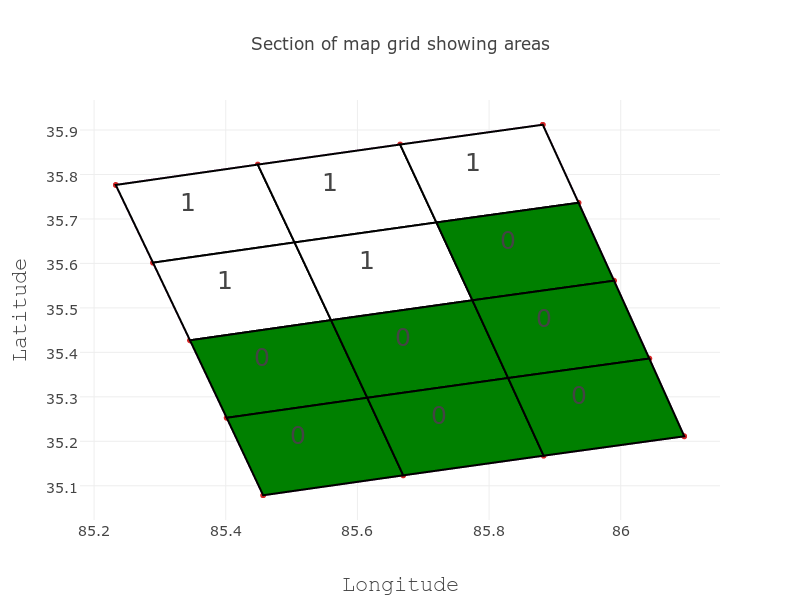

In [10]:
Image("figures/areas_of_sub_section_ii.png")

In [ ]:
def make_annotation(x,y,snow_bool):

    if snow_bool:
        text = '1'
    else:
        text = '0'

    annotation = dict(
            x=x-.025,
            y=y+.025,
            xref='x',
            yref='y',
            text=text,
            showarrow=False,
            font=dict(
                family='sans serif',
                size=25,)
        )
    return annotation

fig5 = fig4

fig5['layout']['colorbar'] = False,
snow_bools = [True] * 5 + [False] * 15   
annotations = list(map( lambda pt: make_annotation(pt[0], pt[1], False), area_df[['long', 'lat']].values))
fig5['layout']['annotations'] = annotations


def make_poly(x,y, snow_bool):
     # filled Polygon
    line_color = 'rgba(0, 0, 0,1)'
    if snow_bool:
        color = 'rgba(5,5,5,1)'
    else:
        color = 'rgba(0,128,0,1)'
    
    shape = {
        'type': 'path',
        'path': ' M'+str(x[0])+','+str(y[0])+'L'+str(x[1])+','+str(y[1])+'L'+str(x[2])+','+str(y[2])+'L'+str(x[3])+','+str(y[3])+'Z',
        'fillcolor': color,
        'line': {
            'color': line_color,
        },
    }
    
    return shape

def get_centroid_coords(area_indexes, centroid_df):
    coords = []    
    snow_bool = [True] * 10 + [False] * 10
    df = centroid_df.set_index(['col', 'row'])[ ['centroid_lat', 'centroid_long'] ]
    for idx in area_indexes:
        col, row = idx
        item = [(df.ix[ (col-1,row)]['centroid_lat'], df.ix[ (col-1,row)]['centroid_long']),
                (df.ix[ (col,row)]['centroid_lat'], df.ix[ (col,row)]['centroid_long']),
                (df.ix[ (col,row-1)]['centroid_lat'], df.ix[ (col,row-1)]['centroid_long']),
                (df.ix[ (col-1,row-1)]['centroid_lat'], df.ix[ (col-1,row-1)]['centroid_long'])]
        coords.append(item)
    coords = np.array(coords)  
    return coords

#get col and row indexes from area_df
area_indexes = area_df[['col', 'row']].values
#return a list containing the centroid coordinates
centroid_polygons = get_centroid_coords(area_indexes, centroid_df)


poly_traces = list(map( lambda pt: make_poly(pt[:,1], pt[:,0], False), centroid_polygons))
                
for i, snow_bool in enumerate(snow_bools):
    if snow_bool:
        poly_traces[i]['fillcolor'] = 'rgba(255,255,255,1)'
        poly_traces[i]['line']['color'] = 'rgba(0,0,0,1)'
        annotations[i]['text'] = '1'

fig5['layout']['annotations'] = annotations
fig5['layout']['shapes'] = poly_traces
#fig['layout'].update(traces=traces)
iplot(fig5, filename = 'grid',validate=False)

<a name="section_three"/> </a>
# 3. Parsing out a timeseries

This section assumes that you have made and saved grid_and_area data frame as a .csv in part 1 of this document. The code listed below will open each .asc file, filter it according to the input lat-long coordinates, and append it to an HDF5 database. Currently, I have it such that I make one database for every year. 

Some files are corrupted or contain errors, especially for the 4x4km files. If there is any issue, the file will be dropped and the program will march on. A note of its occurrence is recorded in the log file created.

The [tibet snow-man](https://github.com/tylertucker202/tibet_snow_man) project contains a jobs folder with a file called test_tibet_24.py that is run to accomplish several tasks; chief among them, this creates a directory containing HDF5 files of filtered and formatted data from .asc files. A copy of this script is provided below. It wont run here, but you can try it when you download my project!

In [10]:
# -*- coding: utf-8 -*-
import logging
reload(logging) #need to reload in spyder
import os
import pdb
import sys
sys.path.append(os.path.join(os.pardir,'jobs'))
from snowCode import makeSnowHDFStore 
from generate_grid_and_area import grid_and_area
from plot_snow_on_map import plotSnow 
from region_parameters import get_test_tibet_24x24_param
from job_functions import plot_points_on_basemap


if __name__ == '__main__':
    
    logging.basicConfig(filename='test_tibet_24.log',level=logging.DEBUG)
    logging.debug('Start of log file')     
    home_dir = os.getcwd()

    
    data_dir = os.path.abspath(os.path.join(os.getcwd() ,os.pardir, 'data'))
    
    
    
    input_dict = get_test_tibet_24x24_param()
    
    ftp_filename = input_dict['ftp_filename']
    filename = input_dict['filename']
    grid_size = input_dict['grid_size']
    no_snow_planet_name = input_dict['no_snow_planet_name']
    lat_grid_filename = input_dict['lat_grid_filename']
    lon_grid_filename = input_dict['lon_grid_filename']
    lat_long_area_filename = input_dict['lat_long_area_filename']
    lat_long_coords = input_dict['lat_long_coords']
    
    
    #initialize object   
    grid_maker = grid_and_area(lat_long_coords,data_dir,no_snow_planet_name,grid_size)
    
    logging.info('make lat long, and area dataframe')
    
    grid_maker.addLatLong(lat_grid_filename,lon_grid_filename)
    grid_maker.reduceLatLong()
    grid_maker.makeNoSnowMap()

    grid_maker.addAreas()
    
    grid_maker.df.to_csv(os.path.join(data_dir,lat_long_area_filename ))
    
    plot_points_on_basemap(filename,grid_maker.df, lat_long_coords, show = False, save = True)




    input_zip_dir = os.path.join(home_dir,os.pardir,'zip_files',ftp_filename)
    
    output_dir = os.path.join(os.getcwd(),'output',filename)
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    #first make hdf5 database using unitTest directory
    makeHDF = makeSnowHDFStore(data_dir,
                               output_dir,
                               input_zip_dir,
                               lat_long_area_filename,
                               lat_long_coords)
    logging.info('Start parsing through compressed files')
    #makeHDF.make_hdf5_files()
    
    df = makeHDF.make_coverage_df()
    df.to_csv(os.path.join(output_dir,filename+'.csv'))
    
    logging.info('Start plotting from database')
    plotHDF = plotSnow(data_dir,lat_long_area_filename,lat_long_coords)
    plotHDF.set_up_grid()
    plotHDF.make_plots_from_HDFStore(output_dir, show = True, save = True)
   

inside get_test_tibet_24x24_param


<a name="section_four"/> </a>
# 4. Comparisons between the timeseries

Time series are created using the .py files in the 'jobs' folder.

## Plot timeseries

Two time series are plotted below, detailing the differences between 24x24km and 4x4km files.

In [54]:
equal_area_filename =  os.path.join(os.getcwd(),os.pardir,'compare_timeseries','24_km_false_coverage.csv')
df_ea = pd.read_csv(equal_area_filename)
df_ea.rename(index=str, columns={u'perc coverage': '24_perc_ea', u'coverage (km^2)': '24km_cov_ea'}, inplace = True)
df_ea.index = pd.to_datetime(df_ea['timestamp'], format='%Y-%m-%d')
df_ea = df_ea[df_ea['24km_cov_ea'] != 0] #remove missing data
df_ea.drop(pd.Timestamp('2014-12-03'), inplace=True) #remove outlier
df_ea.drop(pd.Timestamp('2014-12-04'), inplace=True) #remove outlier

filename_24km = os.path.join(os.getcwd(),os.pardir,'compare_timeseries','24_km.csv')
df_24 = pd.read_csv(filename_24km, index_col='timestamp')
df_24.rename(index=str, columns={u'perc coverage': '24_perc', u'coverage (km^2)': '24km_cov'}, inplace = True)
df_24.index = pd.to_datetime(df_24.index, format='%Y-%m-%d')
df_24 = df_24[df_24['24km_cov'] != 0]
df_24.drop(pd.Timestamp('2014-12-03'), inplace=True) #remove outlier
df_24.drop(pd.Timestamp('2014-12-04'), inplace=True) #remove outlier

idx_24 = pd.date_range(df_24.index.min(), df_24.index.max()) #make dates with no missing days
df_24_re = df_24.reindex(idx_24, fill_value = -999) #redindex df_24 dataframe and fill missing values with -999
s_missing_24 = pd.Series(0,index = df_24_re[df_24_re['24_perc'] == -999].index) #create a series of missing datapoints
        
filename_4km = os.path.join(os.getcwd(),os.pardir,'compare_timeseries','4_km.csv')
df_4 = pd.read_csv(filename_4km,index_col='timestamp')
df_4.rename(index=str, columns={'perc coverage': u'4_perc', u'coverage (km^2)': '4km_cov'}, inplace=True)
df_4.index = pd.to_datetime(df_4.index, format='%Y-%m-%d')
df_4 = df_4[df_4['4km_cov'] != 0] #remove missing data
df_4.drop(pd.Timestamp('2005-02-10'), inplace=True) #remove outlier
df_4.drop(pd.Timestamp('2004-11-12'), inplace=True) #remove outlier
idx_4 = pd.date_range(df_4.index.min(), df_4.index.max()) #make dates with no missing days
df_4_re = df_4.reindex(idx_4, fill_value = -999) #redindex df_24 dataframe and fill missing values with -999
s_missing_4 = pd.Series(0,index = df_4_re[df_4_re['4_perc'] == -999].index) #create a series of missing datapoints


Populating the interactive namespace from numpy and matplotlib


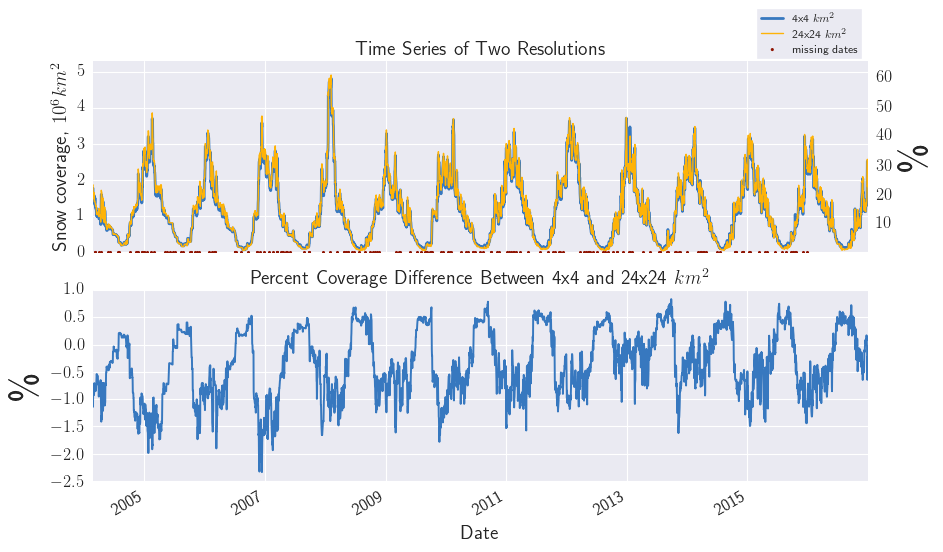

In [59]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

colors = ["windows blue", "amber", "dusty rose", "greyish", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))
percFontsize = 28
lableFontsize = 14

#plot 24 and 4 grids side by side
df_new = pd.concat([df_24,df_4], axis = 1, join = 'inner')

idx_new = pd.date_range(df_new.index.min(), df_new.index.max()) #make dates with no missing days
df_new_re = df_new.reindex(idx_new, fill_value = -999) #redindex df_24 dataframe and fill missing values with -999
s_missing_new = pd.Series(0,index = df_new_re[df_new_re['4_perc'] == -999].index) #create a series of missing datapoints


fig6, axes6 = plt.subplots(nrows=2, ncols=1, sharex=True)

axes6[0].plot(df_4.index.values,df_4['4km_cov'].values/(10**6), linewidth = 2)
axes6[0].plot(df_24.index.values,df_24['24km_cov'].values/(10**6), linewidth = 1)
axes6[0].set_title('Time Series of Two Resolutions')
axes6[0].set_ylabel(r'Snow coverage, $10^{6} km^{2}$')
#axes6[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
axes6[0].set_ylim([0,df_4['4km_cov'].max()*1.1/(10**6)])
axes6[0].set_xlim([df_new.index.min(),df_new.index.max()])
axes6[0].set_xlabel(r'Date')
axes6[0].scatter(s_missing_new.index, s_missing_new, marker = '.', linewidths = 0, c = '#8f1402')


right_ax6 = axes6[0].twinx()
right_ax6.set_ylim([df_4['4_perc'].min()*100,df_4['4_perc'].max()*100*1.1])
right_ax6.set_ylabel('\%', fontsize = percFontsize)
right_ax6.grid(False)


tibet_area = 8059061.81949 #calculated via haversine

resolution_perc_diff = 100 * np.divide(np.subtract(df_new['4km_cov'].values,df_new['24km_cov'].values),df_new['24km_cov'].values)
resolution_diff = np.subtract(df_new['4km_cov'].values,df_new['24km_cov'].values)
percent_coverage_difference = 100 * np.divide(np.subtract(df_new['4km_cov'].values,df_new['24km_cov'].values),tibet_area)

df_new['perc_diff'] = percent_coverage_difference
df_new['perc_diff'].plot(ax=axes6[1])
axes6[1].set_title('Percent Coverage Difference Between 4x4 and 24x24 $km^{2}$')
axes6[1].set_ylabel(r'\%', fontsize = percFontsize)
axes6[1].set_xlabel(r'Date')
axes6[1].set_xlim([df_new.index.min(),df_new.index.max()])

rcTimeSeries = {"font.size":lableFontsize,
                "axes.titlesize":lableFontsize,
                "axes.labelsize":lableFontsize,
                'xtick.labelsize':12,
                'ytick.labelsize':12}
sns.set_context("paper", rc=rcTimeSeries)



df_4['timestamp'] = df_4.index
df_4.index = pd.to_datetime(df_4['timestamp'], format='%Y-%m-%d')
df_4['timestamp'] = pd.to_datetime(df_4['timestamp'], format='%Y-%m-%d').astype(int).astype(float).values

y_4=df_4['4km_cov']
x_4=df_4['timestamp']



axes6[0].legend([r'4x4 $km^{2}$',
                 r'24x24 $km^{2}$',
                 'missing dates'],bbox_to_anchor=(1., 1.3),frameon = True)

In [45]:
print('max resolution percent difference: {}'.format(percent_coverage_difference.max()))
print('min resolution percent difference: {}'.format(percent_coverage_difference.min()))

max resolution percent difference: 0.834671909382
min resolution percent difference: -2.33613673213


The plot below shows the differences between the areas calculated using the shoelace formula and the 24x24km grid assumption. 

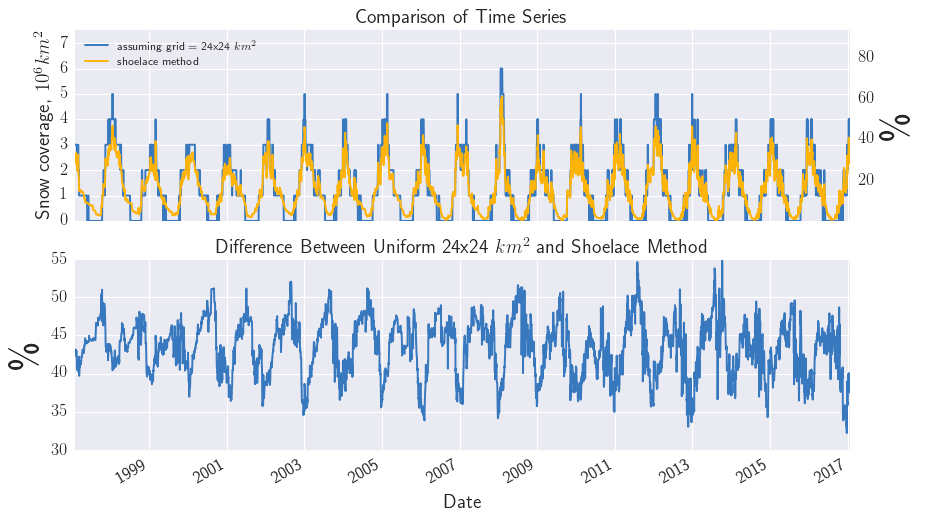

In [66]:
#plot old and new
pylab.rcParams['figure.figsize'] = (10, 6)
df_ea_and_new = pd.concat([df_ea, df_24], axis = 1, join = 'inner')
fig7, axes7 = plt.subplots(nrows=2, ncols=1, sharex=True)

axes7[0].plot(df_ea_and_new.index.values,df_ea_and_new['24km_cov_ea'].values/(10**6))
axes7[0].plot(df_ea_and_new.index.values,df_ea_and_new['24km_cov'].values/(10**6))
axes7[0].set_title('Comparison of Time Series')
axes7[0].set_ylabel(r'Snow coverage, $10^{6} km^{2}$')
axes7[0].set_ylim([df_ea_and_new['24km_cov_ea'].min()/(10**6),df_ea_and_new['24km_cov_ea'].max()*1.1/(10**6)])
axes7[0].set_xlabel(r'Date')
axes7[0].legend(['assuming grid = 24x24 $km^{2}$','shoelace method'], loc=2)

right_ax7 = axes7[0].twinx()

right_ax7.set_ylabel('\%', fontsize = percFontsize)
right_ax7.set_ylim([df_ea_and_new['24km_cov_ea'].min()/tibet_area*100,df_ea_and_new['24km_cov_ea'].max()/tibet_area*100*1.1])
right_ax7.grid(False)


perc_diff = 100 * np.divide( np.subtract(df_ea_and_new['24km_cov_ea'].values, df_ea_and_new['24km_cov'].values) ,df_ea_and_new['24km_cov'].values)
df_ea_and_new['perc_diff'] = perc_diff
df_ea_and_new['perc_diff'].plot(ax=axes7[1])
axes7[1].set_title('Difference Between Uniform 24x24 $km^{2}$ and Shoelace Method')
axes7[1].set_ylabel(r'\%', fontsize = percFontsize)
axes7[1].set_xlabel(r'Date')

In [47]:
print('max method percent difference: {}'.format(df_ea_and_new['perc_diff'].max()))
print('min method percent difference: {}'.format(df_ea_and_new['perc_diff'].min()))

max method percent difference: 54.7943594969
min method percent difference: 32.2199003137


<a name="section_five"/> </a>
# 5 Plotting

Again, test_tibet_24.py contains the routines that generate images of the Tibetian plateau with snowfall data over it. Shown below is the routine The basemap library is used with a contour plot superimposed over it. The contour is set such that snow and ice are shown as white. Reading up on Basemaps functions, you can try out different projections.

In [ ]:
    logging.info('Start plotting from database')
    plotHDF = plotSnow(data_dir,lat_long_area_filename,lat_long_coords)
    plotHDF.set_up_grid()
    plotHDF.make_plots_from_HDFStore(output_dir, show = False, save = True)

The plots created in this page are saved below

In [68]:
fig0_name = 'dry_planet_24km.png'
fig1_name = 'zoomed_earth.png'
fig2_name = 'basemap.png'
fig3_name = 'areas_of_tibet_grid'
fig3p2_name = 'areas_of_tibet_grid_ii'
fig4_name = 'areas_of_sub_section_i'
fig5_name = 'areas_of_sub_section_ii'
fig6_name = 'ts-2-res.png'
fig7_name = 'ts-compare.png'

In [69]:
fig0.savefig(os.path.join(os.getcwd(),os.pardir,os.pardir, 'data','figures',fig0_name))
fig1.savefig(os.path.join(os.getcwd(),os.pardir,os.pardir, 'data','figures',fig1_name))
fig2.savefig(os.path.join(os.getcwd(),os.pardir,os.pardir, 'data','figures',fig2_name))
fig6.savefig(os.path.join(os.getcwd(),os.pardir,os.pardir, 'data','figures',fig6_name))
fig7.savefig(os.path.join(os.getcwd(),os.pardir,os.pardir, 'data','figures',fig7_name))

The interactive plots are a little more difficult to render. You will have to download them and export them yourself.

# Conclusion

So there you have it. This toolkit can be used for researchers and climate scientists, or it can be used by teachers for educational purposes. This is my first python project, so I'm open to suggestions and improvements on my code. Feel free to send a message. I hope that you may find this useful. Thanks for reading! 

This post was created using a jupyter notebook, and can be found [here.](https://github.com/tylertucker202/itsonlyamodel.posts)